In [ ]:
import torch
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles

In [ ]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=25)


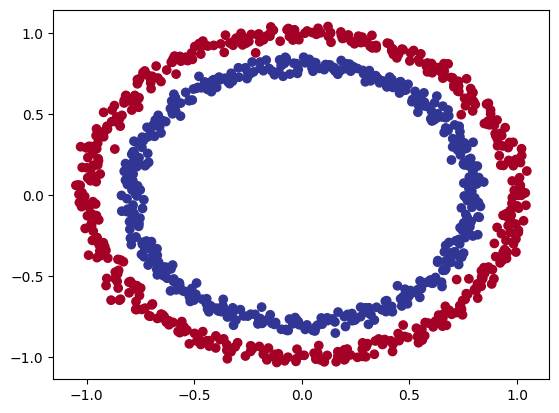

In [ ]:
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

The above data is often reffered as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=25)


In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(750, 250, 750, 250)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to :
1. Setup device agnoistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. create a training and testing loop

In [ ]:
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module`(almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target `device`

In [ ]:
#1. Subclasses nn.Module(almost all models in PyTorch subclass nn.Module)

class CircleModelV0(nn.Module):
  def __init__ (self):
    super().__init__()
    #2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data

    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  #3. Defines a forward() method that outlines the forward pass (or forward computation) of the model
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
#4. Instatiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0 = nn.Sequential(

    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)

).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 250, Shape: torch.Size([250, 1])
Length of test samples: 250, Shape: torch.Size([250, 2])

First 10 predictions:
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])

First 10 labels:
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 1.])


###2.1 setup loss function and optmizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE(Mean Absolute Error) or MSE(Mean Squared Error)

for classification binary cross entropy

loss function measures how *wrong* your models predictions are


In [ ]:
#loss_fn = nn.BCELoss() #-> BCELoss = requires inputs to have gone through the sigmod activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() #-> BCEWithLogitsLoss = sigmoid activation function build-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr = 0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Training the model

To train our model, we're going to need to build a training loop:

1. Forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backward (backpropagation)
5. Optimizer step (gradient descent)

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2741],
        [0.2560],
        [0.3283],
        [0.4548],
        [0.4446]])

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5681],
        [0.5636],
        [0.5814],
        [0.6118],
        [0.6093]])

In [ ]:
y_preds = torch.round(y_pred_probs)

# In full (logits -> preds probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print (torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [ ]:
torch.manual_seed(25)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # trun logits -> pred probs -> pred labels

  #2 Calculate the loss/accuracy

  loss = loss_fn(y_logits, #nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred )
  #3. Optimizer zero grad
  optimizer.zero_grad()
  #4. Loss backward (backpropagation)
  loss.backward()
  #5. Optimizer step (gradient descent)
  optimizer.step()

  ###  Testing

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

  #2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

  # Print out what's happenin'
  if epoch % 250 == 0:
    print(f"Epoch: {epoch}  | Loss: {loss:.5f}, Acc: {acc: 2f}% | Test_loss: {test_loss: .5f}, Test acc: {test_acc:.2f}%")

Epoch: 0  | Loss: 0.71919, Acc:  50.133333% | Test_loss:  0.71665, Test acc: 49.60%
Epoch: 250  | Loss: 0.69277, Acc:  51.333333% | Test_loss:  0.69552, Test acc: 49.20%
Epoch: 500  | Loss: 0.69276, Acc:  50.800000% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 750  | Loss: 0.69276, Acc:  50.800000% | Test_loss:  0.69563, Test acc: 49.20%


## 4. Make predictions and evaluate the model

it looks like there's something wrong about the metric

to inspect it. make some predictions and make them visual

to do so, we're going to import a function called `plot_decision_boundary()`






In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_function.py alreday exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


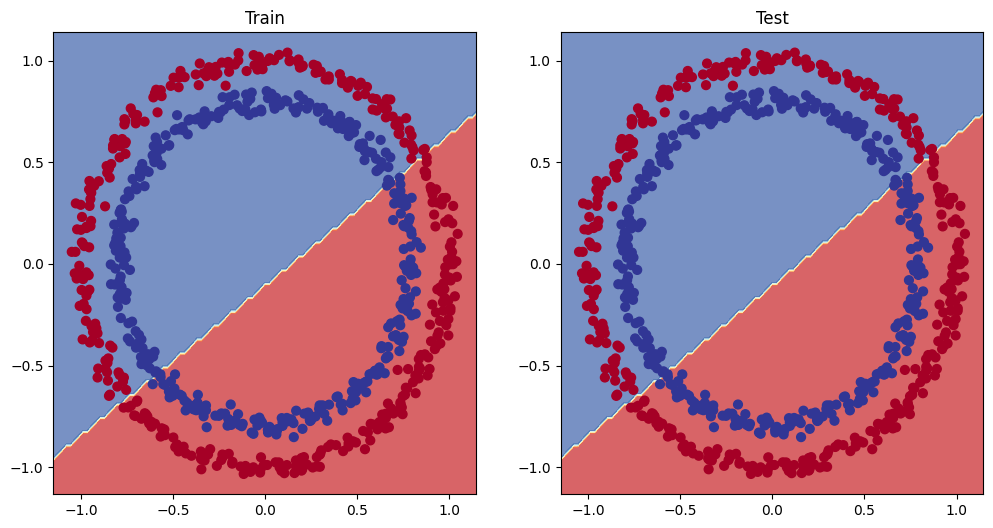

In [ ]:
plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_train, y_train)


##5. Improving a model(from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loos function

 These options are all from a model's perspective because they deal directly with the model, rather than the data.

 And because these options are all valuea we (as machine learning engineers and data scientists) can change, they are called **Hyperparameter**

 Let's try and improve our model by:
    * Adding more hidden units: 5 -> 10
    * Increase the number of layers: 2 -> 3
      * Increase the number of epochs: 100 -> 1000

In [ ]:
class circlemodelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self,x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = circlemodelv1().to(device)
model_1

circlemodelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss functions

loss_fn = nn.BCEWithLogitsLoss()

# create a optimizer

optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)


In [ ]:
torch.manual_seed(25)
torch.cuda.manual_seed(25)


epochs = 1000

for epoch in range(epochs):

  ## Training

  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ### Testing

  model_1.eval()
  with torch.inference_mode():
    test_logit = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    if epoch % 100==0:
      print(f"Epoch: {epoch}  | Loss: {loss:.5f}, Acc: {acc: 2f}% | Test_loss: {test_loss: .5f}, Test acc: {test_acc:.2f}%")

Epoch: 0  | Loss: 0.69906, Acc:  47.733333% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 100  | Loss: 0.69279, Acc:  50.666667% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 200  | Loss: 0.69276, Acc:  50.666667% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 300  | Loss: 0.69276, Acc:  50.933333% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 400  | Loss: 0.69276, Acc:  50.800000% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 500  | Loss: 0.69276, Acc:  50.800000% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 600  | Loss: 0.69276, Acc:  50.800000% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 700  | Loss: 0.69276, Acc:  50.800000% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 800  | Loss: 0.69276, Acc:  50.800000% | Test_loss:  0.69563, Test acc: 49.20%
Epoch: 900  | Loss: 0.69276, Acc:  50.800000% | Test_loss:  0.69563, Test acc: 49.20%


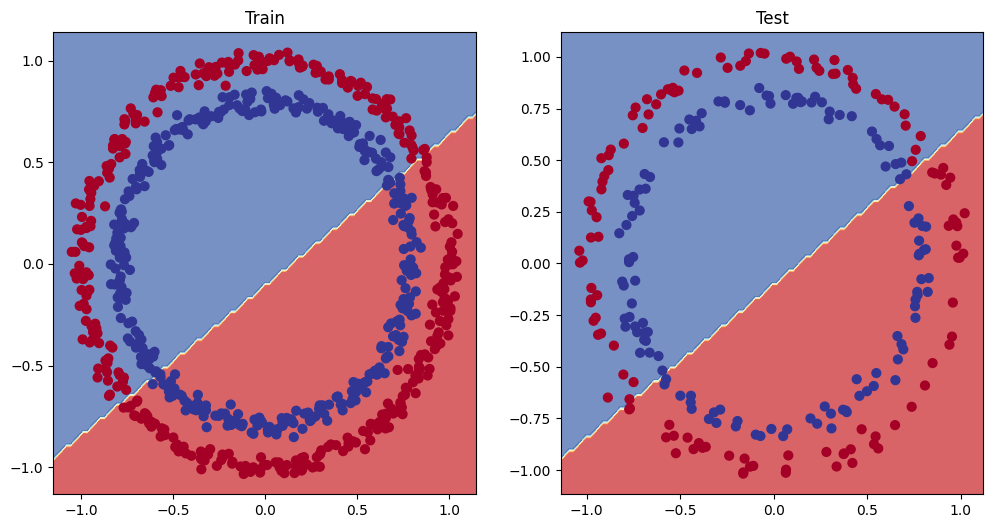

In [ ]:
plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)


### 5.2 Preparing data to see if our model can fit a straight line

In [ ]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias


print(len(X_regression))

100


In [ ]:
train_split =  int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

print(len(X_train_regression),len(X_test_regression),len(y_train_regression), len( y_test_regression))


80 20 80 20


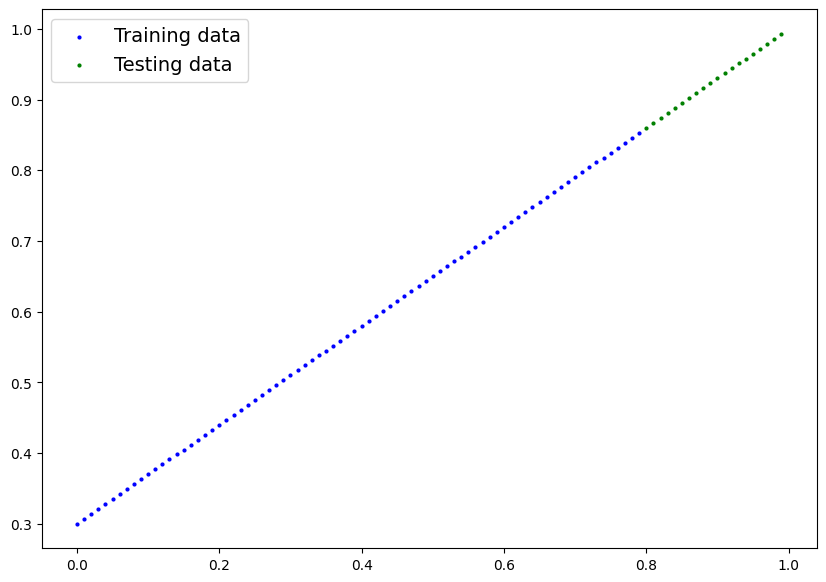

In [ ]:
plot_predictions(train_data = X_train_regression,
                 train_labels =y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression);

In [ ]:
model_1.state_dict

<bound method Module.state_dict of circlemodelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)>

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10, out_features = 10),
    nn.Linear(in_features=10, out_features =1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr = 0.1)

In [ ]:
torch.manual_seed(25)
torch.cuda.manual_seed(25)


epochs = 1000
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):

  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch}| Loss: {loss:.5f}|Test Loss: {test_loss:.5f}|")

Epoch: 0| Loss: 0.67596|Test Loss: 0.54086|
Epoch: 100| Loss: 0.12733|Test Loss: 0.23491|
Epoch: 200| Loss: 0.05070|Test Loss: 0.19081|
Epoch: 300| Loss: 0.07099|Test Loss: 0.15622|
Epoch: 400| Loss: 0.04556|Test Loss: 0.09793|
Epoch: 500| Loss: 0.05113|Test Loss: 0.14128|
Epoch: 600| Loss: 0.05366|Test Loss: 0.10948|
Epoch: 700| Loss: 0.05770|Test Loss: 0.14589|
Epoch: 800| Loss: 0.05025|Test Loss: 0.14401|
Epoch: 900| Loss: 0.06366|Test Loss: 0.14286|


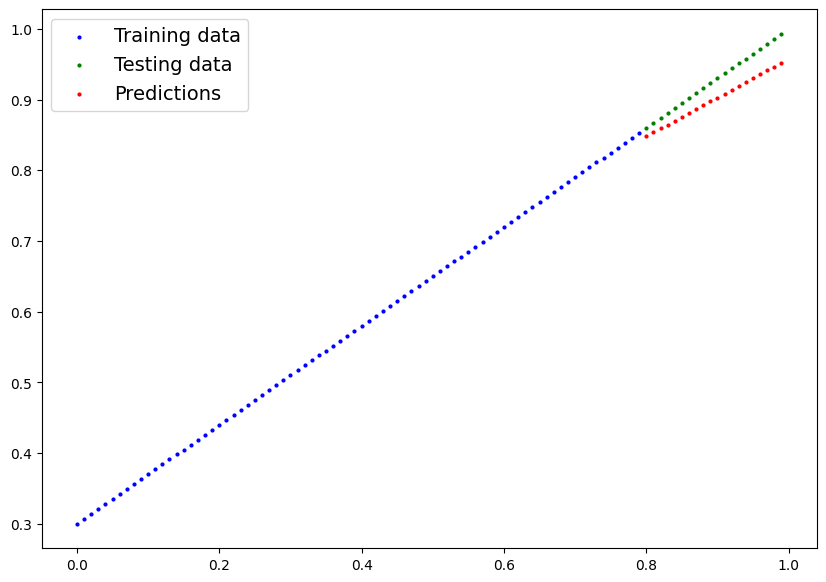

In [ ]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds.cpu());

### Changing the model into non-linear model

### 6.1 Recreating non-linear data (red and blue circles)

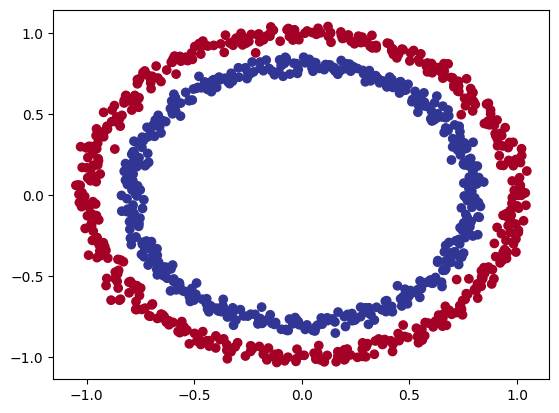

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=25)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=25)

### 6.2 Building a model with non-linearity

  * Linear = straight linear
  * Non-linear = non-straight line

In [ ]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features =  2, out_features = 10)
    self.layer_2 = nn.Linear(in_features =  10, out_features = 10)
    self.layer_3 = nn.Linear(in_features =  10, out_features = 1)
    self.relu = nn.ReLU() # non-linear activation function


  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)

model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_3.parameters(),
                            lr = 0.001)

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


y_test [:5], X_train[:5].squeeze()

(tensor([1., 0., 0., 1., 0.]),
 tensor([[-0.1781,  0.9572],
         [-0.8709,  0.5514],
         [-0.7512,  0.0315],
         [-0.5748, -0.5600],
         [-0.1086, -0.9797]]))

In [ ]:
torch.manual_seed(50)
torch.cuda.manual_seed(50)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc =accuracy_fn(y_true = y_train,
                   y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

  if epoch % 100 == 0:
    print(f"Epoch {epoch}| Loss: {loss:.5f}, accuracy:{acc:.2f}% | Test_loss: {test_loss:.5f}, Test Accuracy = {test_acc:.2f}%")

Epoch 0| Loss: 0.69464, accuracy:50.00% | Test_loss: 0.69478, Test Accuracy = 50.00%
Epoch 100| Loss: 0.69428, accuracy:50.00% | Test_loss: 0.69442, Test Accuracy = 50.00%
Epoch 200| Loss: 0.69401, accuracy:50.00% | Test_loss: 0.69416, Test Accuracy = 50.00%
Epoch 300| Loss: 0.69381, accuracy:50.00% | Test_loss: 0.69396, Test Accuracy = 50.00%
Epoch 400| Loss: 0.69364, accuracy:50.00% | Test_loss: 0.69380, Test Accuracy = 50.00%
Epoch 500| Loss: 0.69350, accuracy:50.00% | Test_loss: 0.69366, Test Accuracy = 50.00%
Epoch 600| Loss: 0.69337, accuracy:50.00% | Test_loss: 0.69353, Test Accuracy = 50.00%
Epoch 700| Loss: 0.69325, accuracy:50.00% | Test_loss: 0.69342, Test Accuracy = 50.00%
Epoch 800| Loss: 0.69315, accuracy:50.00% | Test_loss: 0.69332, Test Accuracy = 50.00%
Epoch 900| Loss: 0.69305, accuracy:50.00% | Test_loss: 0.69322, Test Accuracy = 50.00%


In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds [:10], y_test[:10]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 1.]))

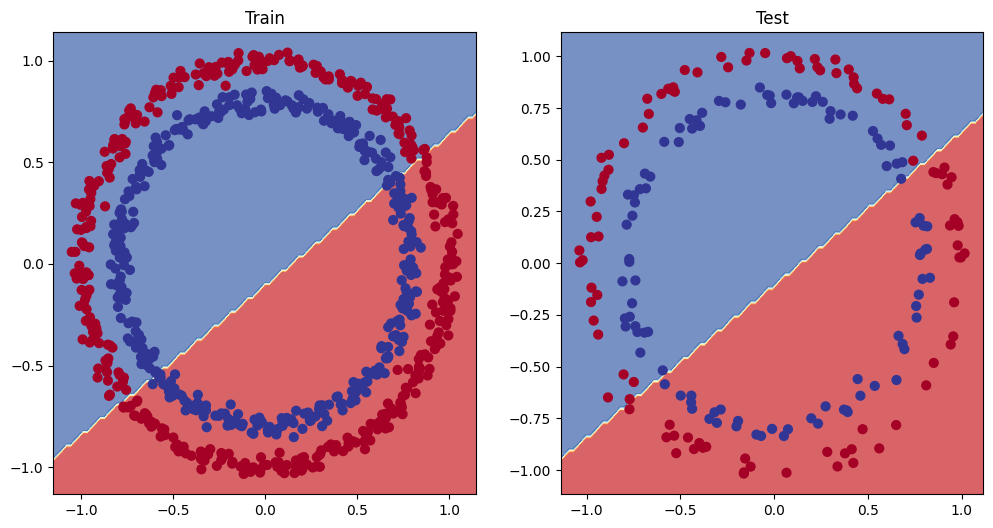

In [ ]:
plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)


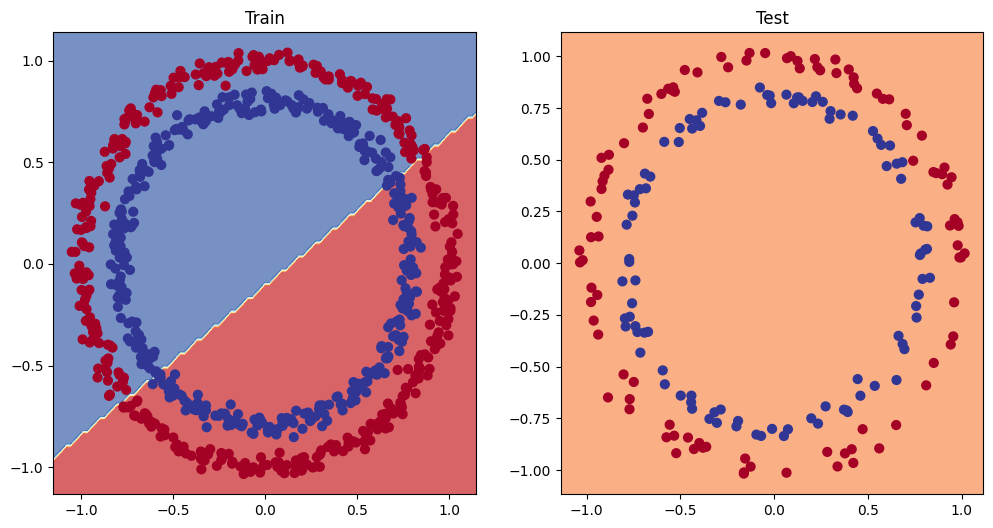

In [ ]:
plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

### 8 Putting it all togerher with a multi-class classification problems

* Binary classification - one thing or another (cat vs dog)
* Multi-class classification - more than one thing or another (rat vs cat vs dog vs chicken)

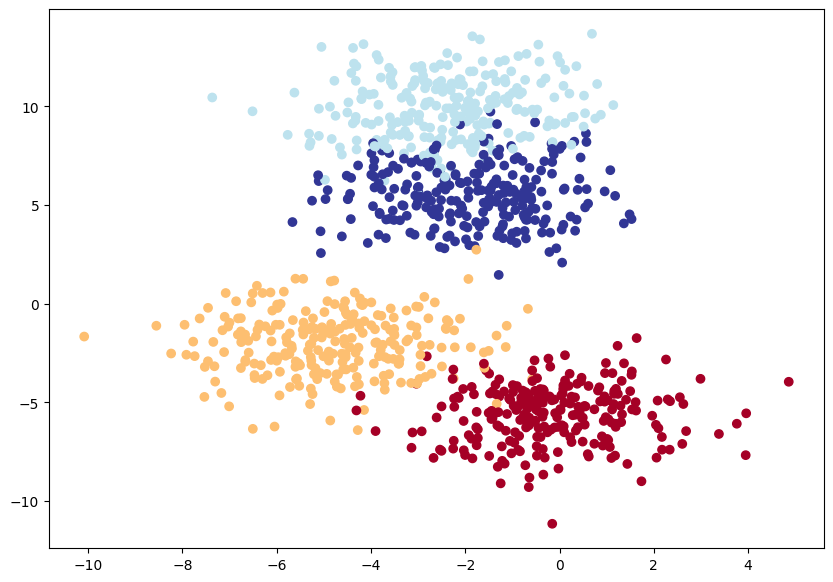

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 50


X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std =1.5,
                            random_state = RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

plt.figure(figsize =(10,7))
plt.scatter(X_blob[:,0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 8.2 Building a multi-class classification model in pytorch

In [ ]:
class blobmodel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    """Initializes multi-class classification model,

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hiddent_units (int) : Number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units , out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units , out_features = output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


model_4 = blobmodel(input_features =2,
                    output_features = 4,
                    hidden_units = 8).to(device)

In [ ]:
y_blob_test.shape

torch.Size([200])

In [ ]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

###8.3 Creating a loss function and an optimizer Multi-class classification

In [ ]:
# Loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# optimizer for multi-class classificationp
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.0001) # learning rate is a hyperparameter you can change


### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and the nto prediction labels.


Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
y_logits[:10]

In [ ]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

In [ ]:
# Conver our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)

y_preds

In [ ]:
y_blob_test

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [ ]:
torch.manual_seed(100)
torch.cuda.manual_seed(100)


epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)
for epoch in range(epochs):

  ## Training
  model_4.train()


  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ## Testing

  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)

    test_acc = accuracy_fn(y_true = y_blob_test,
                      y_pred = test_pred)


    if epoch %10 == 0 :
      print(f"Epoch: {epoch} | loss: {loss:.4f}, acc:{acc:.2f}% | Test loss:{test_loss}, Test acc:{test_acc:.2f}%")



Epoch: 0 | loss: 0.2374, acc:91.38% | Test loss:0.20281082391738892, Test acc:93.50%
Epoch: 10 | loss: 0.2374, acc:91.38% | Test loss:0.2028055042028427, Test acc:93.50%
Epoch: 20 | loss: 0.2374, acc:91.38% | Test loss:0.20280013978481293, Test acc:93.50%
Epoch: 30 | loss: 0.2374, acc:91.38% | Test loss:0.20279477536678314, Test acc:93.50%
Epoch: 40 | loss: 0.2374, acc:91.38% | Test loss:0.20278936624526978, Test acc:93.50%
Epoch: 50 | loss: 0.2374, acc:91.38% | Test loss:0.20278392732143402, Test acc:93.50%
Epoch: 60 | loss: 0.2374, acc:91.38% | Test loss:0.2027784287929535, Test acc:93.50%
Epoch: 70 | loss: 0.2374, acc:91.38% | Test loss:0.20277297496795654, Test acc:93.50%
Epoch: 80 | loss: 0.2374, acc:91.38% | Test loss:0.2027675062417984, Test acc:93.50%
Epoch: 90 | loss: 0.2374, acc:91.38% | Test loss:0.20276199281215668, Test acc:93.50%



### 8.6 Making and evalutaing prediction with pytorch multiclass model


In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)


y_logits[:10]

tensor([[ 4.2789,  5.8824, -3.9944, -0.2382],
        [ 2.9303,  7.8224, -3.9011,  0.9191],
        [ 1.5913, 10.0772, -3.8813,  2.1507],
        [ 8.6885,  1.8462, -4.8112, -3.4421],
        [ 7.1296,  2.9170, -4.4435, -2.3990],
        [-2.1553, -2.7056,  2.0547,  2.3603],
        [-3.2072,  7.5517, -1.1834,  4.5896],
        [-0.2438,  5.4063, -2.0697,  1.9757],
        [ 1.3316,  9.1576, -3.5766,  2.0484],
        [-2.7491, -2.9246,  2.7373,  2.9203]])

In [ ]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs [:10]

tensor([[1.6718e-01, 8.3095e-01, 4.2672e-05, 1.8257e-03],
        [7.4419e-03, 9.9155e-01, 8.0326e-06, 9.9592e-04],
        [2.0625e-04, 9.9943e-01, 8.6635e-07, 3.6087e-04],
        [9.9893e-01, 1.0665e-03, 1.3699e-06, 5.3860e-06],
        [9.8533e-01, 1.4590e-02, 9.2777e-06, 7.1669e-05],
        [6.2355e-03, 3.5966e-03, 4.2000e-01, 5.7016e-01],
        [2.0207e-05, 9.5067e-01, 1.5290e-04, 4.9160e-02],
        [3.3935e-03, 9.6483e-01, 5.4662e-04, 3.1231e-02],
        [3.9873e-04, 9.9878e-01, 2.9450e-06, 8.1655e-04],
        [1.8758e-03, 1.5739e-03, 4.5280e-01, 5.4375e-01]])

In [ ]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_pred[:10]

tensor([2, 0, 3, 0, 1, 3, 0, 2, 3, 1])

In [ ]:
y_blob_test[:10]

tensor([1, 1, 1, 0, 0, 3, 1, 1, 1, 3])

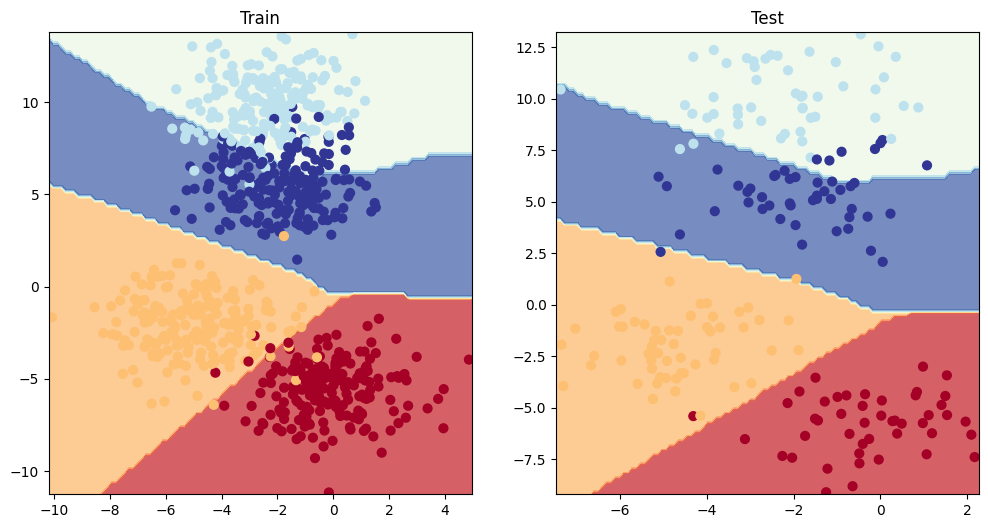

In [167]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)